In [186]:
import numpy as np 
import pandas as pd 
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

%matplotlib inline

In [199]:
!pip install xgboost

## Data preparation & Cleaning

#### Read data with pandas

In [59]:
# Read CSVs into dataframes
players_df = pd.read_csv("./data-raw/players.csv")
games_df = pd.read_csv("./data-raw/games.csv")
appearances_df = pd.read_csv("./data-raw/appearances.csv")

In [60]:
len(players_df), len(games_df), len(appearances_df)

(30302, 64434, 1489578)

In [61]:
players_df.dtypes

player_id                                 int64
first_name                               object
last_name                                object
name                                     object
last_season                               int64
current_club_id                           int64
player_code                              object
country_of_birth                         object
city_of_birth                            object
country_of_citizenship                   object
date_of_birth                            object
sub_position                             object
position                                 object
foot                                     object
height_in_cm                            float64
market_value_in_eur                     float64
highest_market_value_in_eur             float64
contract_expiration_date                 object
agent_name                               object
image_url                                object
url                                     

In [62]:
games_df.dtypes

game_id                     int64
competition_id             object
season                      int64
round                      object
date                       object
home_club_id                int64
away_club_id                int64
home_club_goals             int64
away_club_goals             int64
home_club_position        float64
away_club_position        float64
home_club_manager_name     object
away_club_manager_name     object
stadium                    object
attendance                float64
referee                    object
url                        object
home_club_formation        object
away_club_formation        object
home_club_name             object
away_club_name             object
aggregate                  object
competition_type           object
dtype: object

In [63]:
appearances_df.dtypes

appearance_id             object
game_id                    int64
player_id                  int64
player_club_id             int64
player_current_club_id     int64
date                      object
player_name               object
competition_id            object
yellow_cards               int64
red_cards                  int64
goals                      int64
assists                    int64
minutes_played             int64
dtype: object

#### Take most updated playes data only 

In [64]:
# check most update players's last season 
players_df['last_season'].unique()

array([2014, 2012, 2013, 2015, 2017, 2020, 2018, 2019, 2016, 2021, 2022,
       2023])

In [65]:
players_df = players_df[players_df["last_season"] == 2023]
len(players_df)

6539

#### Merge all data player to get final dataset

In [66]:
games_and_apps_df = appearances_df.merge(games_df, on=['game_id'], how='left')

def get_player_stats(player_id, season, df):
    
    df = df[df['player_id'] == player_id]
    df = df[df['season'] == season]
    
    if (df.shape[0] == 0):
        Out = [(np.nan, season,0,0,0,0,0,0,0)]
        out_df = pd.DataFrame(data = Out, columns = ['player_id','season','goals','games',
                                                     'assists','minutes_played','goals_for','goals_against','clean_sheet'])
        return out_df
    
    else:
        
        df["goals_for"] = df.apply(lambda row: row['home_club_goals'] if row['home_club_id'] == row['player_club_id'] 
                      else row['away_club_goals'] if row['away_club_id'] == row['player_club_id'] 
                      else np.nan, axis=1)
        df["goals_against"] = df.apply(lambda row: row['away_club_goals'] if row['home_club_id'] == row['player_club_id'] 
                      else row['home_club_goals'] if row['away_club_id'] == row['player_club_id'] 
                      else np.nan, axis=1)
        df['clean_sheet'] = df.apply(lambda row: 1 if row['goals_against'] == 0
                      else 0 if row['goals_against'] > 0
                      else np.nan, axis=1)
        
        df = df.groupby(['player_id',"season"],as_index=False).agg({'goals': 'sum', 'game_id': 'nunique', 
                                                                      'assists': 'sum', 'minutes_played' : 'sum', 'goals_for' : 'sum',
                                                                      'goals_against' : 'sum', 'clean_sheet' : 'sum'})
        out_df = df.rename(columns={'game_id': 'games'})

        return out_df
    
    
stat_season = 2022
for index in players_df.index:
    id = players_df.loc[index][0]
    name = players_df.loc[index][1]
    stats = get_player_stats(id, stat_season, games_and_apps_df)
    players_df.at[index,'goals_{}'.format(stat_season)]= stats['goals'][0]
    players_df.at[index,'games_{}'.format(stat_season)]= stats['games'][0]
    players_df.at[index,'assists_{}'.format(stat_season)]= stats['assists'][0]
    players_df.at[index,'minutes_played_{}'.format(stat_season)]= stats['minutes_played'][0]
    players_df.at[index,'goals_for_{}'.format(stat_season)]= stats['goals_for'][0]
    players_df.at[index,'goals_against_{}'.format(stat_season)]= stats['goals_against'][0]
    players_df.at[index,'clean_sheet_{}'.format(stat_season)]= stats['clean_sheet'][0]

In [67]:
players_df.columns

Index(['player_id', 'first_name', 'last_name', 'name', 'last_season',
       'current_club_id', 'player_code', 'country_of_birth', 'city_of_birth',
       'country_of_citizenship', 'date_of_birth', 'sub_position', 'position',
       'foot', 'height_in_cm', 'market_value_in_eur',
       'highest_market_value_in_eur', 'contract_expiration_date', 'agent_name',
       'image_url', 'url', 'current_club_domestic_competition_id',
       'current_club_name', 'goals_2022', 'games_2022', 'assists_2022',
       'minutes_played_2022', 'goals_for_2022', 'goals_against_2022',
       'clean_sheet_2022'],
      dtype='object')

In [68]:
# we dont have age column, but can construct it from date of birth
players_df['date_of_birth'] = pd.to_datetime(players_df['date_of_birth'])


players_df = players_df[players_df['date_of_birth'].isnull() == False]
now = datetime.now()

players_df['age'] = (now - players_df['date_of_birth']).apply(lambda x: x.days) / 365.25
players_df['age'] = players_df['age'].round().astype(int)

#### Handling missing value with drop 

In [69]:
players_df.isnull().sum()

player_id                                  0
first_name                               384
last_name                                  0
name                                       0
last_season                                0
current_club_id                            0
player_code                                0
country_of_birth                         362
city_of_birth                            360
country_of_citizenship                     0
date_of_birth                              0
sub_position                               2
position                                   0
foot                                     222
height_in_cm                             225
market_value_in_eur                       46
highest_market_value_in_eur               45
contract_expiration_date                 226
agent_name                              2000
image_url                                  0
url                                        0
current_club_domestic_competition_id       0
current_cl

In [70]:
# we only care missing value in importants columns
players_df = players_df.dropna(subset = ['foot','height_in_cm','market_value_in_eur','highest_market_value_in_eur'])
players_df.isnull().sum()

player_id                                  0
first_name                               378
last_name                                  0
name                                       0
last_season                                0
current_club_id                            0
player_code                                0
country_of_birth                         225
city_of_birth                            225
country_of_citizenship                     0
date_of_birth                              0
sub_position                               0
position                                   0
foot                                       0
height_in_cm                               0
market_value_in_eur                        0
highest_market_value_in_eur                0
contract_expiration_date                 179
agent_name                              1839
image_url                                  0
url                                        0
current_club_domestic_competition_id       0
current_cl

In [71]:
len(players_df)

6170

In [72]:
#reset index of dataset
players_df = players_df.reset_index(drop=True)
players_df

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,...,current_club_domestic_competition_id,current_club_name,goals_2022,games_2022,assists_2022,minutes_played_2022,goals_for_2022,goals_against_2022,clean_sheet_2022,age
0,22860,Jesper,Hansen,Jesper Hansen,2023,678,jesper-hansen,Denmark,Slangerup,Denmark,...,DK1,Aarhus GF,0.0,25.0,0.0,2250.0,37.0,22.0,9.0,39
1,30321,Óscar,Trejo,Óscar Trejo,2023,367,oscar-trejo,Argentina,Santiago del Estero,Argentina,...,ES1,Rayo Vallecano,3.0,37.0,5.0,2306.0,47.0,52.0,8.0,36
2,38780,Vítor,Gomes,Vítor Gomes,2023,2425,vitor-gomes,Portugal,Vila do Conde,Portugal,...,PO1,Rio Ave FC,0.0,22.0,1.0,826.0,28.0,30.0,8.0,36
3,40204,Joe,Hart,Joe Hart,2023,371,joe-hart,England,Shrewsbury,England,...,SC1,Celtic FC,0.0,44.0,0.0,3960.0,124.0,42.0,17.0,37
4,43250,Jan,Vertonghen,Jan Vertonghen,2023,58,jan-vertonghen,Belgium,Sint-Niklaas,Belgium,...,BE1,RSC Anderlecht,1.0,25.0,0.0,2078.0,37.0,36.0,9.0,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6165,1025424,Solomon,Agbalaka,Solomon Agbalaka,2023,41231,solomon-agbalaka,NaN,NaN,Nigeria,...,RU1,FC Sochi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20
6166,284732,Ramy,Bensebaini,Ramy Bensebaini,2023,16,ramy-bensebaini,Algeria,Constantine,Algeria,...,L1,Borussia Dortmund,7.0,30.0,1.0,2570.0,55.0,44.0,9.0,29
6167,371851,Jaka,Bijol,Jaka Bijol,2023,410,jaka-bijol,Slovenia,Vuzenica,Slovenia,...,IT1,Udinese Calcio,3.0,33.0,2.0,2805.0,39.0,39.0,10.0,25
6168,586756,Festy,Ebosele,Festy Ebosele,2023,410,festy-ebosele,Ireland,"Enniscorthy, Wexford",Ireland,...,IT1,Udinese Calcio,0.0,18.0,1.0,446.0,20.0,27.0,4.0,21


## EDA

### Basic Statistic

In [73]:
#see each column data statistic
for col in players_df.columns:
    print("========== {} ==========".format(col) )
    print("sample data: {} ".format(players_df[col].unique()[:5]))
    print("no. of unique value: {} ".format(players_df[col].nunique()))
    print()

========== player_id ==========
sample data: [22860 30321 38780 40204 43250] 
no. of unique value: 6170 

========== first_name ==========
sample data: ['Jesper' 'Óscar' 'Vítor' 'Joe' 'Jan'] 
no. of unique value: 2463 

========== last_name ==========
sample data: ['Hansen' 'Trejo' 'Gomes' 'Hart' 'Vertonghen'] 
no. of unique value: 5364 

========== name ==========
sample data: ['Jesper Hansen' 'Óscar Trejo' 'Vítor Gomes' 'Joe Hart' 'Jan Vertonghen'] 
no. of unique value: 6135 

========== last_season ==========
sample data: [2023] 
no. of unique value: 1 

========== current_club_id ==========
sample data: [ 678  367 2425  371   58] 
no. of unique value: 238 

========== player_code ==========
sample data: ['jesper-hansen' 'oscar-trejo' 'vitor-gomes' 'joe-hart' 'jan-vertonghen'] 
no. of unique value: 6133 

========== country_of_birth ==========
sample data: ['Denmark' 'Argentina' 'Portugal' 'England' 'Belgium'] 
no. of unique value: 141 

========== city_of_birth ==========
sample da

#### player's age distribution

<Axes: xlabel='age'>

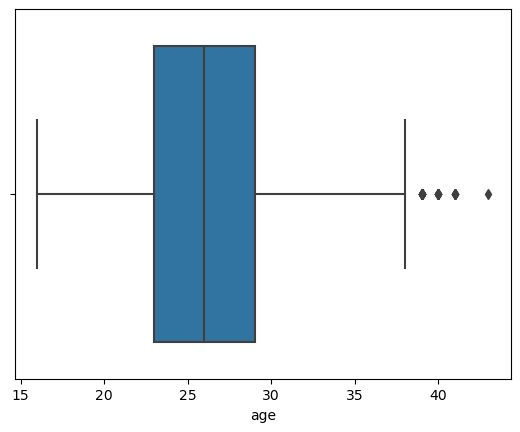

In [74]:
sns.boxplot(x=players_df["age"])

<Axes: xlabel='age', ylabel='Count'>

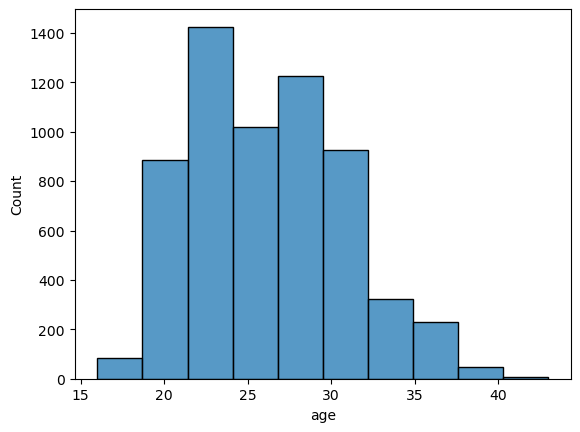

In [75]:
sns.histplot(players_df.age, bins=10)

#### The most goal player in 2022

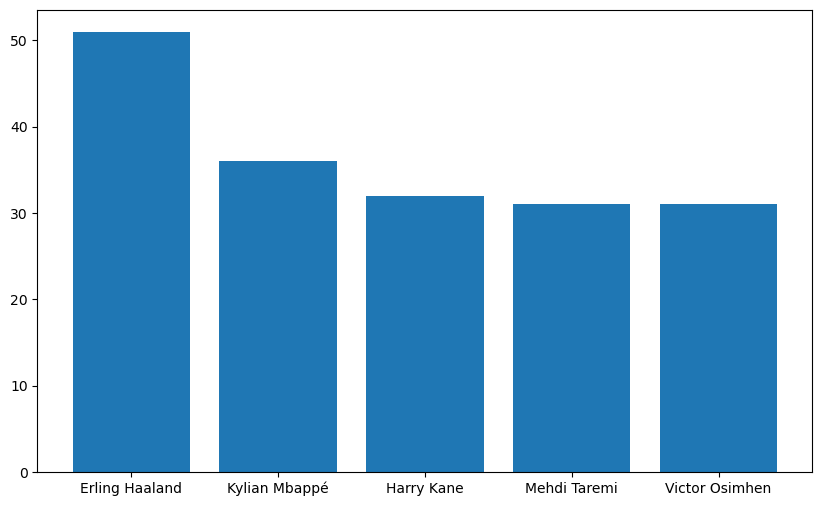

In [76]:
top5_names = players_df.sort_values(by=['goals_2022'], ascending=False).head(5)['name']
top5_goals = players_df.sort_values(by=['goals_2022'], ascending=False).head(5)['goals_2022']

fig = plt.figure(figsize =(10, 6))
 
plt.bar(top5_names, top5_goals)
 
# Show Plot
plt.show()

#### Highest market value player in 2023 (in Euro)

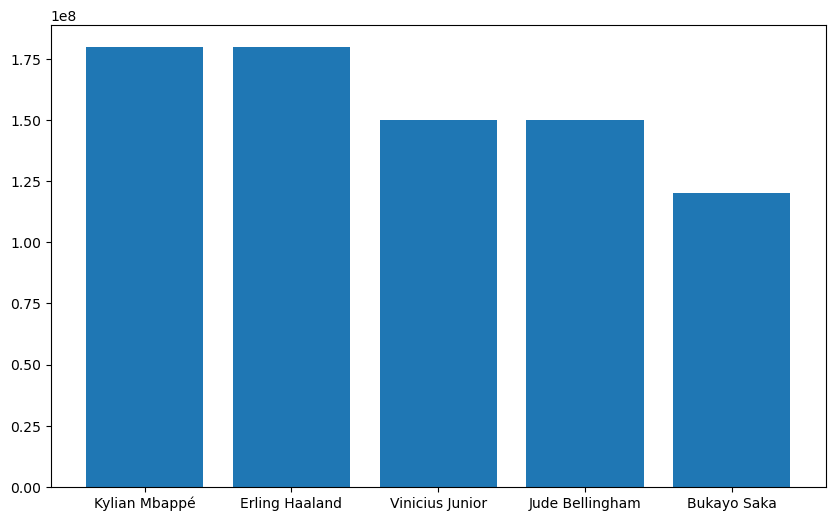

In [77]:
top5_names = players_df.sort_values(by=['market_value_in_eur'], ascending=False).head(5)['name']
top5_market_values = players_df.sort_values(by=['market_value_in_eur'], ascending=False).head(5)['market_value_in_eur']

fig = plt.figure(figsize =(10, 6))
 
plt.bar(top5_names, top5_market_values)
 
# Show Plot
plt.show()

### Target Variable Analysis

Here we use market_value_in_eur column as our target variable \
market_value_in_eur is latest value of the player in euro currency

<Axes: xlabel='market_value_in_eur', ylabel='Count'>

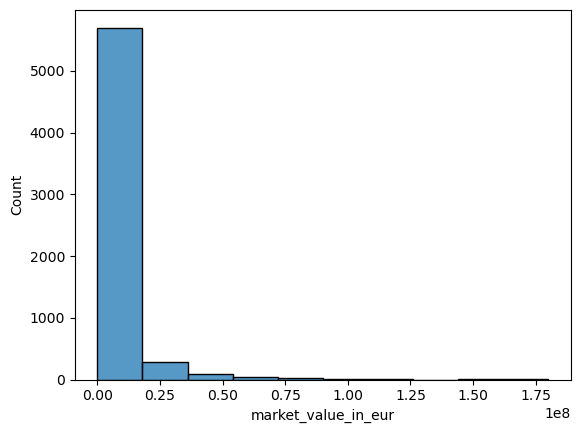

In [78]:
#show the distribution of player's market value
#looked a long tail distribution
sns.histplot(players_df['market_value_in_eur'], bins=10)

<Axes: xlabel='market_value_in_eur', ylabel='Count'>

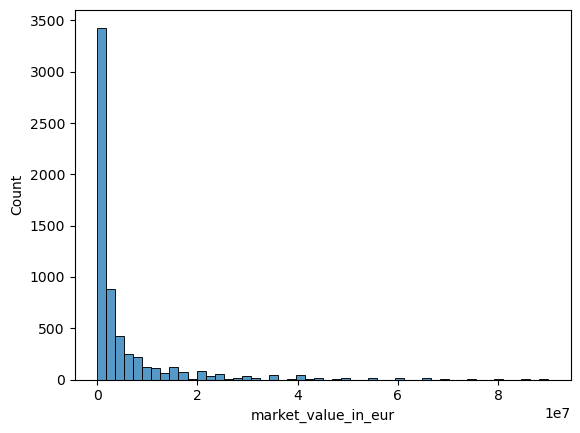

In [79]:
#zoom in to below 1000000000
sns.histplot(players_df['market_value_in_eur'][players_df['market_value_in_eur'] < 100000000], bins=50)

In [80]:
#Applies log transformation to a variable and adds one to each result for normalize the distribution
#Log transformation makes great distance of data dissemination become smaller
#here we transform the distribution to normal dist since long tail dist often confuse the ML models
market_value_logs = np.log1p(players_df['market_value_in_eur'])

<Axes: xlabel='market_value_in_eur', ylabel='Count'>

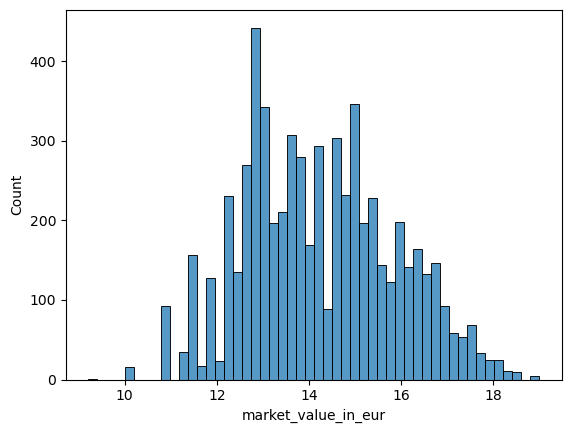

In [81]:
sns.histplot(market_value_logs, bins=50)

### Feature Importance Analysis

In [82]:
players_df.dtypes

player_id                                        int64
first_name                                      object
last_name                                       object
name                                            object
last_season                                      int64
current_club_id                                  int64
player_code                                     object
country_of_birth                                object
city_of_birth                                   object
country_of_citizenship                          object
date_of_birth                           datetime64[ns]
sub_position                                    object
position                                        object
foot                                            object
height_in_cm                                   float64
market_value_in_eur                            float64
highest_market_value_in_eur                    float64
contract_expiration_date                        object
agent_name

In [83]:
#pick relavant feature to train and divide it based the type of data
numerical_features = ['height_in_cm',
                      'goals_2022',
                      'games_2022',
                      'assists_2022',
                      'minutes_played_2022',
                      'goals_for_2022',
                      'goals_against_2022',
                      'clean_sheet_2022',
                      'age'
                     ]
categorical_features = ['position',
                        'sub_position',
                        'foot',
                        'current_club_name',
                        'current_club_domestic_competition_id'
                       ]

#### Categorical data importance analysis: mutual information

In [84]:
mutual_info_score(players_df.market_value_in_eur, players_df.position)

0.06008489366697176

In [85]:
def mutual_info_marketvalue_score(series):
    return mutual_info_score(series, players_df.market_value_in_eur)

In [86]:
mi = players_df[categorical_features].apply(mutual_info_marketvalue_score)
mi.sort_values(ascending=False)

current_club_name                       1.359951
current_club_domestic_competition_id    0.436970
sub_position                            0.134787
position                                0.060085
foot                                    0.017598
dtype: float64

#### Numerical data importance analysis: pearson correlation

In [87]:
players_df[numerical_features].corrwith(players_df.market_value_in_eur).abs()

height_in_cm           0.018153
goals_2022             0.465034
games_2022             0.444302
assists_2022           0.448892
minutes_played_2022    0.448644
goals_for_2022         0.521528
goals_against_2022     0.326417
clean_sheet_2022       0.486316
age                    0.066511
dtype: float64

## SPLIT DATASET

In [88]:
from sklearn.model_selection import train_test_split

In [89]:
df_full_train, df_test = train_test_split(players_df, test_size=0.2, random_state=1)

In [90]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [91]:
len(df_train), len(df_val), len(df_test)

(3702, 1234, 1234)

In [92]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [93]:
#applies log transformation for each target "y" to each datasets
y_train = np.log1p(df_train.market_value_in_eur.values)
y_val = np.log1p(df_val.market_value_in_eur.values)
y_test = np.log1p(df_test.market_value_in_eur.values)

In [94]:
#remove target "y" data to make sure target not included in training process
del df_train["market_value_in_eur"]
del df_val["market_value_in_eur"]
del df_test["market_value_in_eur"]

## Metrics

In [95]:
def rmse(y, y_pred):
    error = y - y_pred
    se = error ** 2
    mse = se.mean()
    return np.sqrt(mse)

## Train Baseline Model

Use all numerical feature (without categorical and feature selection) for baseline model \
Baseline model is use linear regression

In [103]:
def prepare_X(df):
    X = df.values
    return X

In [104]:
X_train = prepare_X(df_train[numerical_features])

reg = LinearRegression().fit(X_train, y_train)

X_val = prepare_X(df_val[numerical_features])

y_pred = reg.predict(X_val)

rmse(y_val, y_pred)

1.1880720139678733

## Train Model

### Linear Regression 

In [169]:
#Prepare data with one hot encoding
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_features + numerical_features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical_features + numerical_features].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [170]:
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_val)
rmse(y_val, y_pred)

0.8808473953366259

#### Linear Regression with Ridge Regularization

In [181]:
regRidge = Ridge(alpha=0.1)
regRidge.fit(X_train, y_train)
y_pred = regRidge.predict(X_val)
rmse(y_val, y_pred)

0.8802673591296154

#### Linear Regression with Lasso Regularization

In [180]:
regLasso = Lasso(alpha=0.1)
regLasso.fit(X_train, y_train)
y_pred = regLasso.predict(X_val)
rmse(y_val, y_pred)

1.1588110808933716

#### Tuning model

From the three linear regression model we got "linear regression with ridge" as the best. now we fine tune the alpha of the best model

In [182]:
for alpha in [0.0, 0.00001, 0.0001, 0.001, 0.1, 1, 10]:
    regRidge = Ridge(alpha=alpha)
    regRidge.fit(X_train, y_train)
    y_pred = regRidge.predict(X_val)
    print("==== RMSE ====")
    print("alpha={} : {} ".format(alpha,rmse(y_val, y_pred)))
    

==== RMSE ====
alpha=0.0 : 1.8856287154443736 
==== RMSE ====
alpha=1e-05 : 0.8808406269481698 
==== RMSE ====
alpha=0.0001 : 0.8808400969144246 
==== RMSE ====
alpha=0.001 : 0.8808347979932456 
==== RMSE ====
alpha=0.1 : 0.8802673591296154 
==== RMSE ====
alpha=1 : 0.8762951957983706 
==== RMSE ====
alpha=10 : 0.8745470450162509 


In [184]:
#the best model is : linear regression with ridge regularization with alpha=10
best_linear_model = Ridge(alpha=10)
best_linear_model.fit(X_train, y_train)

Ridge(alpha=10)

### Decision Tree

In [196]:
rf = DecisionTreeRegressor(max_depth=2, random_state=1)
rf.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2, random_state=1)

In [197]:
y_pred = rf.predict(X_val)
y_pred

array([13.38580757, 15.05114391, 15.05114391, ..., 15.05114391,
       15.05114391, 13.38580757])

In [198]:
round(rmse(y_val, y_pred),3)

1.231